<font color="#CA3532" size=5><b>Clasificación Polisomnogramas<b></font><br>
<font color="#6E6E6E"><b>Ciencia de Datos en Biomedicina - Máster en Ciencia de Datos</b></font><br><br>
<font color="#252525">Oriol de la Pau Chacón Albero<br>Sergio Manuel Conde Sánchez</font>

In [1]:
#Importación de paquetes
import mne
import pandas as pd
import numpy as np
import yasa
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import shap

# Preprocesado y elección de canales

En este trabajo intentaremos clasificar cada una de las fases en que se encuentra un paciente a partir de su polisomnograma. Utilizaremos un dataset extraído de la web de ISRUC-SLEEP (https://sleeptight.isr.uc.pt/). El conjunto que nosotros usaremos está compuesto por los 10 pacientes sanos del subgrupo 3 (emplearemos el 1 y 10 para validación y los 8 restantes para entrenamiento), de los cuales tenemos la lectura de distintos canales perteneciente a cada uno de los electrodos. Todo esto va acompañado de las etiquetas asignadas a mano por dos doctores distintos y una serie de anotaciones hechas durante la toma de datos.

Para la extracción de información de los distintos hipnogramas emplearemos un paquete llamado Yasa, especializado en estos tipos de datos. Así, podremos cargar y manipular las lecturas, además de extraer las características necesarias para la detección de las fases. Para esto último existe la función *SleepStaging*, que tiene como parámetros de entrada los canales *eeg* (actividad cerebral), *eog* (actividad ocular), *emg* (actividad muscular). 

Para la elección de los canales nos hemos fijado en el paper de Khalighi Sirvan, Teresa Sousa, José Moutinho Santos, y Urbano Nunes. "ISRUC-Sleep: A comprehensive public dataset for sleep researchers" (https://www.researchgate.net/publication/283734463_ISRUC-Sleep_A_comprehensive_public_dataset_for_sleep_researchers). Cargaremos los datos por tanto en varias etapas, aprovechando que tenemos múltiples lecturas de eeg, eog y emg; y en cada una de estas etapas utilizaremos la función SleepStaging pero variando la configuración de los canales. También utilizaremos las anotaciones durante la toma de datos para excluir todas aquellas fases que presenten artefactos y por tanto, puedan ser sujeto de error.

El modelo seleccionado para la clasificación es el RandomForest (nos daba mejores reultados que el SVC). Iremos entrenando el modelo a medida que añadimos features para observar si mejora. Una vez recogidas todas, haremos feature selection a partir del mismo modelo entrenado y será ese el modelo final. Nos centraremos, principalmente, en optimizar la precisión al máximo, esto es, disminuir la cantidad de fases mal clasificadas todo lo posible. El objetivo es asegurarnos de que las clases predichas sean correctas, para que se pueda confiar en el modelo con esas etiquetas y reducir la carga de trabajo al doctor encargado de clasificarlas. Para ello, la estrategia consistirá en modificar el treshold a la probabilidad del modelo final (a partir de la curba ROC) de manera que aquellos periodos del sueño con baja probabilidad no sean etiquetadas dentro de ninguna fase. Este umbral se puede modificar por el usuario. 

Finalmente, introducimos una herramienta (Shap Values) que permite desgranar los resultados del clasificador, observando las probabilidades de cada clase así como los factores (valor y peso en el modelo de las variables) que han llevado a ese resultado, para cualquier muestra individual. De este modo, aunque algunas fases no quedan clasificadas por nuestro modelo, el médico encargado de supervisarlo tiene una herramienta que le ayude a tomar una decisión.

In [2]:
#Comenzamos definiendo la función que nos extraera los indices de aquellas fases en las que haya artefactos.
def find_art(X):
    ind = []
    pattern1 = r'[a-z]'
    pattern2 = r'nan'
    for i in range(len(X)):
        if re.search(pattern1, str(X.loc[i][0])) or not re.search(pattern2, str(X.loc[i][1])):
            ind.append(i)
    return ind

## Etapa 1 (Preprocesado)

Ahora, comenzaremos con la primera parte de la extracción de biomarcadores. En este caso, utilizaremos la siguiente configuración: *eeg_name="C3-A2", eog_name = 'LOC-A2', emg_name = 'X1'*. El preprocesado de la señal será el mismo en todas las etapas. Comenzamos cargando los datos y eliminando los canales que no utilizaremos, después haremos un resample de la señal a 100 Hz y filtraremos las frecuencias entre 0.3-50Hz, por último, eliminamos las últimas 30 fases de la señal, además de todas aquellas que presentan artefactos. Es importante notar que hemos elegido las etiquetas del Experto nº2, simplemente porque obteníamos mejores resultados con el clasificador final.

In [3]:
def prepro(X): #el input será la ruta del archivo
    raw = mne.io.read_raw_edf(X+'.edf', preload=True)
    # Drop unused channels
    raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
    #Downsampling and filtering
    raw.resample(100)
    raw.filter(0.3, 49.9, verbose = False);
    #Eliminamos 30 ultimas fases
    raw = raw.crop(tmin=0, tmax=(raw.last_samp-30*100*30+1)/100)
    #Cargamos las fases ya etiquetadas
    hypno = np.loadtxt(X+'_2.txt', dtype=int)
    hypno[hypno == 5] = 4
    hypno = hypno[0:hypno.shape[0]-30] #eliminamos 30 ultimas fases
    #Cargamos el excel para buscar los artefactos
    hypno_x= pd.read_excel(X + '_2.xlsx', usecols = 'D:E')
    hypno_x = hypno_x[0:hypno_x.shape[0]-30]
    ind = find_art(hypno_x)
    
    #Sacamos la matriz de caracteristicas
    sls = yasa.SleepStaging(raw, eeg_name="C3-A2", eog_name = 'LOC-A2', emg_name = 'X1')
    features = sls.get_features().drop(ind) #eliminamos las muestras que presentan artefactos
    hypno = np.delete(hypno, ind) #eliminamos las etiquetas correspondientes a los artefactos
    return raw, features, hypno, ind

In [4]:
# Cargamos los 10 pacientes
raw_10,features_10, hypno_10, ind_10 = prepro('10/10')
raw_9,features_9, hypno_9, ind_9 = prepro('9/9')
raw_8,features_8, hypno_8, ind_8 = prepro('8/8')
raw_7,features_7, hypno_7, ind_7 = prepro('7/7')
raw_6,features_6, hypno_6, ind_6 = prepro('6/6')
raw_5,features_5, hypno_5, ind_5 = prepro('5/5')
raw_4,features_4, hypno_4, ind_4 = prepro('4/4')
raw_3,features_3, hypno_3, ind_3 = prepro('3/3')
raw_2,features_2, hypno_2, ind_2 = prepro('2/2')
raw_1,features_1, hypno_1, ind_1 = prepro('1/1')

Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\7\7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4883999  =      0.000 ... 24419.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\B

In [5]:
#1 y 10 para test, el resto train. Los concatenamos en dos datasets
features_train = pd.concat([features_2,features_3, features_4,
                      features_5, features_6, features_7, features_8, features_9], ignore_index = True)
features_test = pd.concat([features_1,features_10], ignore_index = True)

hypno_train = np.concatenate((hypno_2,hypno_3, hypno_4,
                      hypno_5, hypno_6, hypno_7, hypno_8, hypno_9))
hypno_test = np.concatenate((hypno_1,hypno_10))

## Etapa 1 (Clasificación)

Comenzamos entrenando el Random Forest con las variables extraídas de tan solo la primera configuración de canales. Vemos que tiene una precisión del 84%, con especial éxito en las fases 3 y REM. No obstante, presenta problemas clasificando la fase 1, confundiéndola con la de vigilia y la 2

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       263
           1       0.88      0.52      0.66       249
           2       0.73      0.90      0.81       460
           3       0.96      0.83      0.89       292
           4       0.91      0.74      0.82       231

    accuracy                           0.81      1495
   macro avg       0.85      0.79      0.80      1495
weighted avg       0.83      0.81      0.81      1495



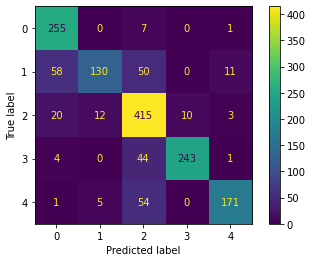

In [11]:
clf = RandomForestClassifier(max_depth = 9, random_state=0, n_estimators=300)
clf.fit(features_train, hypno_train)
hypno_pred = clf.predict(features_test)

print(classification_report(hypno_test, hypno_pred))
cm = confusion_matrix(hypno_test, hypno_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

## Etapa 2 (preprocesado)

Utilizaremos la misma estrategia que antes pero esta vez añadiremos los siguientes canales: *eeg_name="C4-A1", eog_name = 'ROC-A1'*

In [7]:
def prepro2(X): #el input será la ruta del archivo
    raw = mne.io.read_raw_edf(X+'.edf', preload=True)
    # Drop unused channels
    raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
    #Downsampling and filtering
    raw.resample(100)
    raw.filter(0.3, 49.9, verbose = False);
    #Eliminamos 30 ultimas fases
    raw = raw.crop(tmin=0, tmax=(raw.last_samp-30*100*30+1)/100)
    #Cargamos las fases ya etiquetadas
    hypno = np.loadtxt(X+'_2.txt', dtype=int)
    hypno[hypno == 5] = 4
    hypno = hypno[0:hypno.shape[0]-30] #eliminamos 30 ultimas fases
    #Cargamos el excel para buscar los artefactos
    hypno_x= pd.read_excel(X + '_2.xlsx', usecols = 'D:E')
    hypno_x = hypno_x[0:hypno_x.shape[0]-30]
    ind = find_art(hypno_x)
    
    #Sacamos la matriz de caracteristicas
    sls = yasa.SleepStaging(raw, eeg_name="C4-A1", eog_name = 'ROC-A1', emg_name = 'X3')
    features = sls.get_features().drop(ind) #eliminamos las muestras que presentan artefactos
    features.columns += '_2'
    hypno = np.delete(hypno, ind) #eliminamos las etiquetas correspondientes a los artefactos
    return raw, features, hypno, ind

In [8]:
raw_10_2,features_10_2, hypno_10, ind_10 = prepro2('10/10')
raw_9_2,features_9_2, hypno_9, ind_9 = prepro2('9/9')
raw_8_2,features_8_2, hypno_8, ind_8 = prepro2('8/8')
raw_7_2,features_7_2, hypno_7, ind_7 = prepro2('7/7')
raw_6_2,features_6_2, hypno_6, ind_6 = prepro2('6/6')
raw_5_2,features_5_2, hypno_5, ind_5 = prepro2('5/5')
raw_4_2,features_4_2, hypno_4, ind_4 = prepro2('4/4')
raw_3_2,features_3_2, hypno_3, ind_3 = prepro2('3/3')
raw_2_2,features_2_2, hypno_2, ind_2 = prepro2('2/2')
raw_1_2,features_1_2, hypno_1, ind_1 = prepro2('1/1')

Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\Biomedicina\PSG\7\7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4883999  =      0.000 ... 24419.995 secs...
Extracting EDF parameters from C:\Users\Usuario\Documents\Master\B

In [9]:
#1 y 10 para test, el resto train. Los concatenamos
features_train_aux = pd.concat([features_2_2,features_3_2, features_4_2,
                      features_5_2, features_6_2, features_7_2, features_8_2, features_9_2], ignore_index = True)
features_test_aux = pd.concat([features_1_2,features_10_2], ignore_index = True)

features_train_2 = pd.concat([features_train, features_train_aux], axis = 1)
features_test_2 = pd.concat([features_test, features_test_aux], axis = 1)

features_test_2

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm_2,eog_skew_p2min_norm_2,eog_std_2,eog_std_c7min_norm_2,eog_std_p2min_norm_2,eog_theta_2,eog_theta_c7min_norm_2,eog_theta_p2min_norm_2,time_hour_2,time_norm_2
0,1.574026,0.206254,-0.032613,0.215258,0.270039,0.404668,2.877216,0.776767,0.863531,0.153471,...,0.562020,0.056941,3.769551,1.454329,1.907977,0.041670,-0.744761,-0.836208,0.008333,0.001083
1,8.795979,0.203146,0.312557,0.097140,0.260529,0.251614,0.646465,0.776161,0.567164,0.191300,...,0.607477,0.032407,3.517386,1.289891,1.712023,0.034603,-0.683338,-0.851187,0.016667,0.002167
2,5.435957,0.161582,0.358221,0.138546,0.261276,0.220399,2.047879,0.798632,0.584523,0.196502,...,0.677767,0.343807,4.044599,1.127310,1.698243,0.040797,-0.613529,-0.847094,0.025000,0.003250
3,2.720448,0.108465,0.373679,0.167789,0.263731,0.197389,2.179481,0.814727,0.584569,0.325654,...,0.712178,0.077161,3.151944,0.942964,1.386220,0.068210,-0.536855,-0.793511,0.033333,0.004334
4,1.218134,0.058043,0.360236,0.166493,0.261892,0.144024,1.765135,0.820882,0.453204,0.446836,...,0.791025,0.749991,2.134136,0.753271,1.125039,0.122581,-0.457516,-0.642227,0.041667,0.005417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,1.781053,0.112310,0.185262,0.054127,0.083145,-0.109272,0.345966,0.056382,-0.006415,0.010035,...,-0.184438,-0.015664,1.144548,-0.021510,-0.021325,0.144143,0.096110,0.095957,6.341667,0.994771
1491,0.950431,0.093843,0.154515,0.120660,0.148310,0.033465,0.502163,0.107086,-0.031619,0.030464,...,-0.168637,0.029260,0.886746,-0.016699,-0.046667,0.181106,0.094545,0.166247,6.350000,0.996078
1492,1.147038,0.080372,0.137764,0.087149,0.195626,0.066290,0.466350,0.151942,0.005048,0.021755,...,-0.151140,-0.005180,0.997854,0.001383,-0.052131,0.145863,0.081047,0.130122,6.358333,0.997386
1493,1.100564,0.069937,0.082739,0.120357,0.242856,0.258761,0.705795,0.200061,0.197898,0.098477,...,-0.120347,0.009432,2.337073,0.036407,0.115276,0.113464,0.058999,0.100994,6.366667,0.998693


## Etapa 2 (clasificación)

Vemos que los resultados mejoran ligeramente al añadir estos tres nuevos canales. Empeoramos con la clase 0 (74% a 70%) y con la 4 (92% a 91%), pero por otro lado mejoramos en la 1 (85% a 89%), en la 2 (74% a 78%) y en la 3 (95% a 96%). De media mejoramos un 1%. Nos quedaremos entonces con este modelo y trataremos de mejorar los resultados con el feature selection.

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       263
           1       0.89      0.51      0.65       249
           2       0.78      0.88      0.83       460
           3       0.96      0.85      0.90       292
           4       0.91      0.80      0.85       231

    accuracy                           0.82      1495
   macro avg       0.85      0.80      0.81      1495
weighted avg       0.84      0.82      0.81      1495



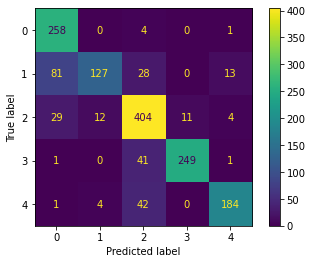

In [10]:
clf = RandomForestClassifier(max_depth = 9, random_state=0, n_estimators=300)
clf.fit(features_train_2, hypno_train)
hypno_pred = clf.predict(features_test_2)

print(classification_report(hypno_test, hypno_pred))
cm = confusion_matrix(hypno_test, hypno_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

## Feature Selection

Una vez recogidas las características necesarias, intentaremos reducir su número seleccionando las más importantes para nuestro modelo. Para ello, hemos representado en una gráfica su importancia y hemos escogido un treshold para el cual nuestros resultados eran óptimos. No hemos conseguido mejorar los resultados pero si hemos conseguido disminuir el espacio de características en más de 100 dimensiones sin apenas afectar a los resultados. 

Es importante comentar que además de las características aquí extraídas hemos probado a extraer tanto el ratio de zero crossing como la desviación estándar del resto de canales pero no se han obtenido mejoras apreciables en el modelo. Tampoco han funcionado los métodos de reducción de dimensionalidad como PCA ni la normalización de los datos. 

### Random Forest features

Index(['eeg_abspow', 'eeg_abspow_c7min_norm', 'eeg_abspow_p2min_norm',
       'eeg_alpha', 'eeg_alpha_c7min_norm', 'eeg_alpha_p2min_norm', 'eeg_at',
       'eeg_at_c7min_norm', 'eeg_at_p2min_norm', 'eeg_beta',
       ...
       'eog_perm_2', 'eog_petrosian_2', 'eog_petrosian_p2min_norm_2',
       'eog_sdelta_c7min_norm_2', 'eog_sigma_c7min_norm_2', 'eog_std_2',
       'eog_std_c7min_norm_2', 'eog_std_p2min_norm_2', 'eog_theta_2',
       'eog_theta_c7min_norm_2'],
      dtype='object', length=189)


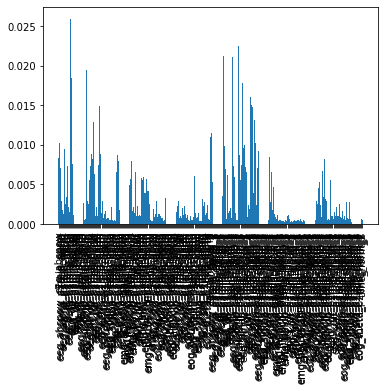

In [12]:
# todas las variables:
names = features_train_2.columns

# representa la importancia en el random forest
plt.bar(names,clf.feature_importances_)
plt.xticks(rotation = 90)
# muestra las 34 más importantes que seleccionaremos
print(names[clf.feature_importances_>0.001])
features_train_ext = features_train_2.copy().loc[:,clf.feature_importances_>0.001]
features_test_ext = features_test_2.copy().loc[:,clf.feature_importances_>0.001]

Se obtienen ahora unos resultados casi calcados a los de la segunda etapa, con problemas sobre todo distinguiendo la clase 1.

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       263
           1       0.88      0.53      0.67       249
           2       0.79      0.88      0.83       460
           3       0.94      0.85      0.90       292
           4       0.91      0.81      0.86       231

    accuracy                           0.82      1495
   macro avg       0.85      0.81      0.81      1495
weighted avg       0.84      0.82      0.82      1495



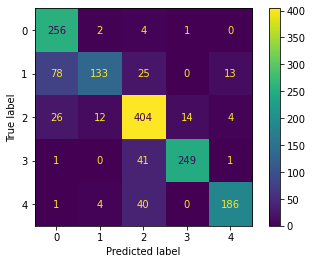

In [13]:
clf_ext = RandomForestClassifier(max_depth = 9, random_state=0, n_estimators=300)
clf_ext.fit(features_train_ext, hypno_train)
hypno_pred = clf_ext.predict(features_test_ext)

print(classification_report(hypno_test, hypno_pred))
cm = confusion_matrix(hypno_test, hypno_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

# Modelo óptimo
## Curva ROC

Pasaremos ahora, a validar el modelo con la curva ROC. Esto nos ayudará a comprender cómo afecta la elección del treshold a nuestra precisión y cuales son las clases más problemáticas. Para calcular las curvas utilizaremos las probabilidades calculadas con el Random Forest. Hemos probado los dos enfoques  *one vs all* y *all vs all* y nos hemos quedado con este último al ser el que mejor nos separa las clases.

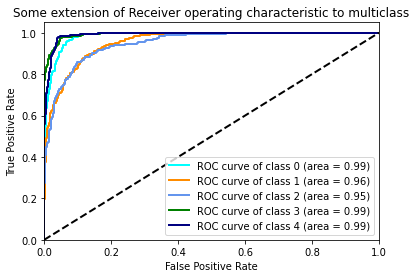

In [14]:
y_score = clf_ext.predict_proba(features_test_ext)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
tresh = dict()
roc_auc = dict()

# Binarize the output
hypno_test_bin = label_binarize(hypno_test, classes=[0, 1, 2, 3, 4])
n_classes = hypno_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], tresh[i] = roc_curve(hypno_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(hypno_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# representamos curva ROC
plt.figure()
colors = ["aqua", "darkorange", "cornflowerblue", 'green', "navy"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
    
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

De nuevo, vemos que los problemas de clasficiación están entre la clase 1 y 2, pero con unos muy buenos resultados en general, con áreas bajo la curva cercanas a la unidad. Usaremos los tresholds obtenidos en este apartado para realizar la clasificación final de las fases del sueño. La estrategia consistirá en forzar un 98% de Verdaderos positivos en cada clase, de manera que podamos asegurar que los datos clasificados son correctos y le quitemos carga de trabajo al médico encargado, a expensas de dejar fases sin clasificar.

In [15]:
max_0 = max(np.where(fpr[0] <=0.002, fpr[0],tresh[0]))
max_1 = max(np.where(fpr[1] <=0.002, fpr[1],tresh[1]))
max_2 = max(np.where(fpr[2] <=0.002, fpr[2],tresh[2]))
max_3 = max(np.where(fpr[3] <=0.002, fpr[3],tresh[3]))
max_4 = max(np.where(fpr[4] <=0.002, fpr[4],tresh[4]))

In [16]:
a = []
for i in range(len(y_score)):
    if y_score[i][0] > max_0:
        a.append(0)
    elif y_score[i][1] > max_1:
        a.append(1)
    elif y_score[i][2] > max_2:
        a.append(2)
    elif y_score[i][3] > max_3:
        a.append(3)
    elif y_score[i][4] > max_4:
        a.append(4)
    else:
        a.append(5) # clase 5 = muestras no clasificadas por falta de confianza

Haciendo esto, obtenemos un 48% de muestras clasificadas, donde un 51% no están clasificadas y solo un 1% está clasificado incorrectamente. Esto significa que con este modelo el trabajo de etiquetación del médico se reducirá a casi la mitad. Otra ventaja que presenta este método es que podemos elegir manualmente la precisión por clase. Esto nos permite darle más importancia a una clase sobre otra o a elegir un mínimo de precisión a partir del cual el modelo es válido para uso clínico.

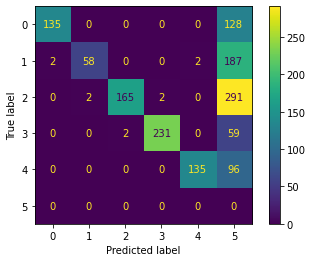

In [17]:
cm = confusion_matrix(hypno_test, a)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0, 1, 2, 3, 4, 5]))
disp.plot()

plt.show()

# Explicabilidad del modelo

El desarrollo del Machine Learning los últimos años ha permitido grandes avances en ámbitos muy diversos. Sin embargo, presenta una limitación importante: algunos modelos (como las redes profundas) son lo que conocemos como 'caja negra' (no podemos desgranar cómo se ha llegado a las conclusiones de forma exacta). Ésto supone un motivo de desconfianza especialmente (aunque no sólo) en el ámbito de la biomedicina ya que si decides operar o subministrar una dosis de un medicamento a un determinado paciente debes poder justificar esta decisión. Por este motivo, en los últimos años se han introducido nuevos métodos des del campo de la Explainable Artificial Inteligence (XAI) tratando de mejorar la interpretabilidad de los modelos.

En el caso concreto de nuestro modelo, hemos utilizado un Random Forest, el cual nos permite extraer la importancia que se le ha otorgado a cada variable a la hora de construir el clasificador. Por lo tanto, no se trata de una caja negra sinó que aporta algo de información. Sin embargo, seguimos sin saber cómo afecta exactamente a la clasificación el hecho de modificar el valor de una variable; si la importancia de las características es diferente para cada clase; o qué factores han decidido que una muestra individual se clasifique de una forma determinada.

Para intentar resolver todas estas cuestiones utilizaremos el algoritmo SHAP (SHapley Additive exPlanations), basado en la teoría de juegos cooperativos. Los valores de Shapley nos dan un peso para la aportación de cada variable a la predicción de una determinada muestra (en este caso la probabilidad de pertenecer a una clase) después de considerar las diferentes posibles combinaciones. Estos pesos se pueden observar de forma individual o promediar sobre el total de la clase para sacar nuevas conclusiones. Además, esta herramienta puede servir de soporte para ayudar a clasificar las fases no clasificadas por nuestro modelo o para obtener más detalles sobre una muestra concreta:

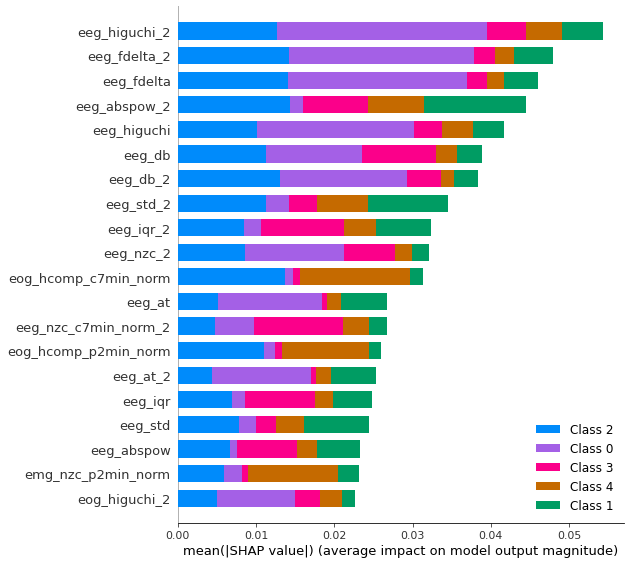

In [18]:
explainer = shap.TreeExplainer(clf_ext)
shap_values = explainer.shap_values(features_test_ext)
shap.summary_plot(shap_values, features_test_ext)

En primer lugar observamos la importancia media de cada variable para definir cada clase. Observamos que características obtenidas del encefalograma como eeg_higuchi (Higuchi fractal dimension) o eeg_fdelta tienen mayor peso en general (especialmente para las clases 0 y 2). En cambio, para la fase REM (clase 4) observamos como ganan mucho peso las variables de actividad ocular eog, como cabría esperar. 

También podemos desgranar el impacto de cada variable por clases en función del valor de la variable:

Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase:  0


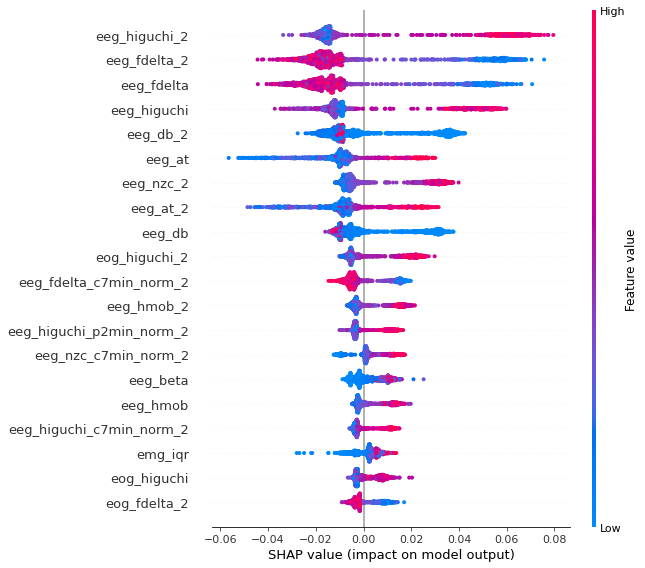

Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase:  1


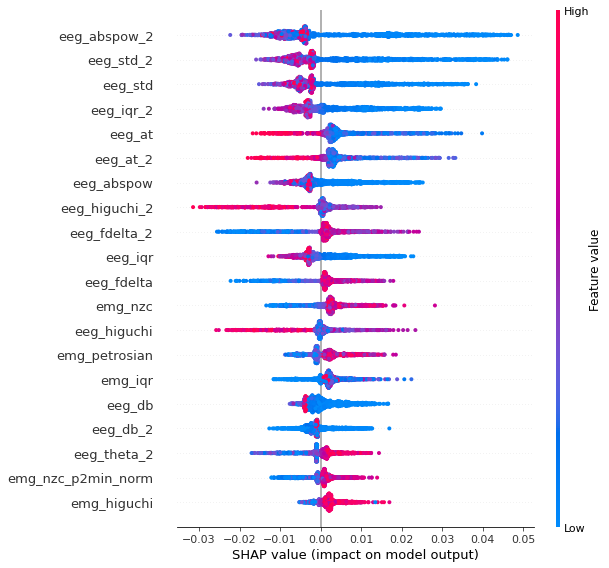

Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase:  2


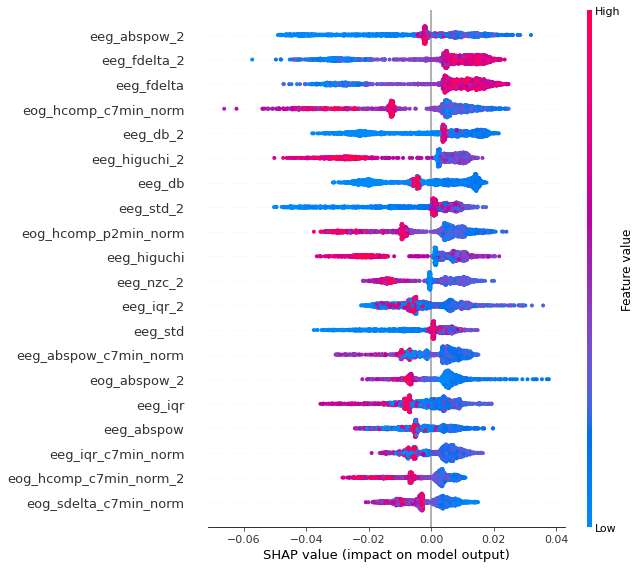

Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase:  3


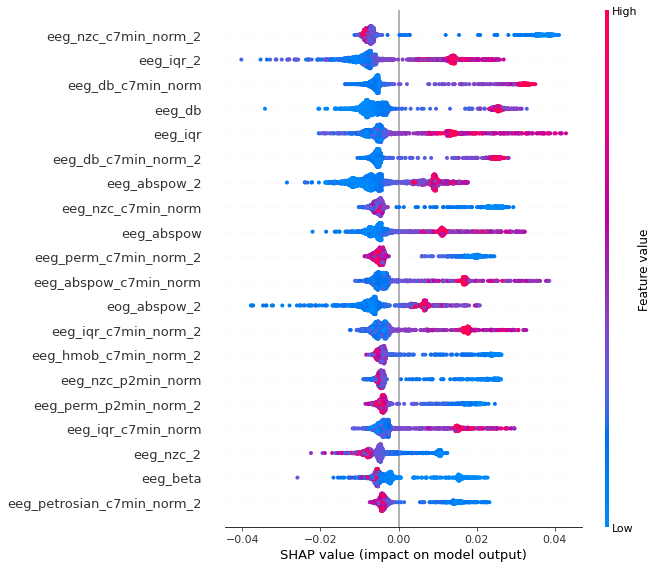

Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase:  4


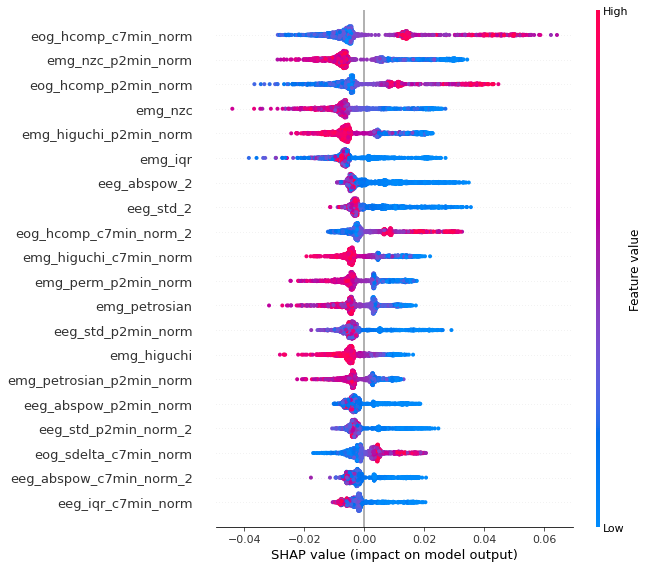

In [19]:
for i in range(5):
    print('Distribución del impacto de cada variable en la predicción del modelo para las muestras de clase: ', i)
    shap.summary_plot(shap_values[i], features_test_ext.values, feature_names = features_test_ext.columns)

Cómo interpretamos estos gráficos? El color indica el valor de cada variable: rojo es un valor alto y azul un valor bajo. Cada punto representa una muestra del dataset de test. Por lo tanto vemos una distribución del valor de cada variable para todas las muestras en función de si aumentan (hacia la derecha) o disminuyen la probabilidad de que dicha muestra pertenezca a cada una de las clases. Así, por ejemplo, un valor de eeg_higuchi alto y de eeg_fdelta bajo aumentan en gran medida la probabilidad de pertenecer a la clase 0; mientra que un valor de eog_hcomp_c7min_norm ocular alto aumenta mucho la probabilidad de pertenecer a la clase 4. 

Una vez analizada la influencia de cada variable de forma general podemos inspeccionar como se forman las predicciones para una muestra individual:

***(es necesario activar el modo Trust this Notebook para visualizar la representación)***

In [20]:
# muestra correctamente clasificada
ind = np.array(np.where(np.logical_and(np.array(a) == 4, hypno_test == 4)))[0,0]

shap.initjs()
for j in range(5):
    print('Factores que influyen en la probabilidad de que esta muestra sea de clase: ', j)
    display(shap.force_plot(explainer.expected_value[j], shap_values[j][ind], features_test_ext.values[ind], feature_names = features_test_ext.columns))

Factores que influyen en la probabilidad de que esta muestra sea de clase:  0


Factores que influyen en la probabilidad de que esta muestra sea de clase:  1


Factores que influyen en la probabilidad de que esta muestra sea de clase:  2


Factores que influyen en la probabilidad de que esta muestra sea de clase:  3


Factores que influyen en la probabilidad de que esta muestra sea de clase:  4


Así, observamos que la probabilidad de que una muestra corresponda a una clase determinada viene dada por el base value (proporción de muestras de esa clase sobre el total) más la suma de los Shap Values de todas las variables. Así podemos visualizar lo que ha hecho el modelo en cualquier muestra. Así, en cada caso el valor de las variables representadas en rojo en la muestra seleccionada 'empujan' hacia arriba la probabilidad de que pertenezca a cada clase mientras que los azules disminuyen esta probabilidad. 

Por lo tanto, en este caso concreto la muestra se ha clasificado con bastante confianza como fase REM (clase 4) coincidiendo efectivamente con su etiqueta. Podemos desgranar el resultado: La probabilidad de que la muestra sea clase 0 o 3 es prácticamente nula ya que prácticamente todas las variables tienen pesos Shap negativos (equivalente a decir que todas las variables en esta muestra tienen valores que nuestro modelo considera incompatibles con pertenecer a estas clases). También observamos una probabilidad muy baja de pertenecer a las clases 1 y 2 cercana al base value (los pesos positivos y negativos suman prácticamente 0). En cambio, la probabilidad de pertenecer a la clase 4 es muy alta (0.82), ya que prácticamente todas las variables toman valores que el modelo considera compatibles con esta clase, destacando la importancia de eog_hcomp_c7min y emg_nzc, las cuales tienen más peso en la decisión.

Esta herramienta puede servir para justificar por qué se ha clasificado una muestra concreta de una forma; para comparar los criterios definidos históricamente por los médicos con los biomarcadores encontrados mediante Machine Learning; así cómo herramienta para ayudar a etiquetar a mano las muestras que nuestro modelo no es capaz de clasificar con suficiente confianza. Veamos un ejemplo:

In [27]:
# seleccionamos la primera muestra con predicción errónea
ind = np.array(np.where(hypno_test != hypno_pred))[0,0] # predicha como 0 pero es clase 1

for j in range(5):
    print('Factores que influyen en la probabilidad de que esta muestra sea de clase: ', j)
    display(shap.force_plot(explainer.expected_value[j], shap_values[j][ind], features_test_ext.values[ind], feature_names = features_test_ext.columns))

Factores que influyen en la probabilidad de que esta muestra sea de clase:  0


Factores que influyen en la probabilidad de que esta muestra sea de clase:  1


Factores que influyen en la probabilidad de que esta muestra sea de clase:  2


Factores que influyen en la probabilidad de que esta muestra sea de clase:  3


Factores que influyen en la probabilidad de que esta muestra sea de clase:  4


En este caso concreto, podemos descartar claramente que la muestra pertenezca a las clases 2, 3 y 4, por el muy bajo valor de sus respectivas probabilidades (por debajo del base value). La muestra ha sido clasificada como clase 0 (despierto), pero su etiqueta nos indica que realmente (según el experto) pertenece a la clase 1. En la matriz de confusión veíamos que se trata de un error bastante típico. La probabilidad de pertenecer a la clase 0 es más del doble que a la clase 1. Sin embargo, nuestro modelo final no tiene suficiente confianza en el resultado como para clasificarlo. Por lo tanto, el médico que deba revisarlo y asignar la etiqueta definitiva se puede servir de estos gráficos: por ejemplo, debería fijarse en los valores de las variables higuchi y fdelta del encefalograma que en nuestro modelo han tenido bastante importancia a la hora de adjudicar la clase 0 y no la 1.

## Conclusiones

Hemos utilizado un Random Forest, con un enfoque *all vs all*, al que le aplicamos posteriormente un threshold arbitrario. De esta manera, hemos obtenido un modelo capaz de clasificar casi el 50% de las fases del sueño de un paciente test, con un 98% de precisión, lo que supone un gran ahorro de esfuerzo al personal encargado de la tarea. Cabe destacar que el modelo inicial era capaz de clasificar todas las muestras con un grado alto de acierto, a expensas de un número significativo de muestras incorrectamente clasificadas, lo cual limitaba su uso médico. La elección manual del threshold en la precisión es lo que nos permite hacer uso clínico del modelo, ya que podemos exigir la precisión necesaria para ello, pudiendo aumentar hasta el 100% si hiciera falta. Estos valores de precisión se han seleccionado con nuestros datos a partir de la curba ROC (para la cual conocemos las etiquetas). Por lo tanto, en casos reales la precisión puede variar, aunque consideramos que será similar ya que se ha calculado sobre datos test (desconocidos por el modelo).

Otra ventaja del modelo obtenido es la explicabilidad que nos ofrece: somos capaces de explicar qué variables tienen más peso, y en qué medida, a la hora de clasificar tanto una muestra individual cómo en conjunto; así como el efecto que tiene en la predicción si modificamos el valor de cualquier variable. Esto supone una gran ventaja tanto en el caso de tener que justificar una decisión clínica basada en el modelo, cómo en el caso de necesitar una ayuda a la hora de etiquetar las fases a mano.

Aún así, para mejoras futuras del modelo, sería interesante comprobar si alguno de los canales no utilizados aportan información importante. También se podría encontrar una forma de combinar la opinión de los dos expertos, o incluso recurrir a más expertos y utilizar métodos estadísticos para verificar las etiquetas. Además, sería fundamental conocer la opinión del médico sobre la importancia de la precisión en las distintas clases, permitiéndonos centrarnos en aquellas más importantes, así como dejando claro cuál es el objetivo preciso que buscamos. Por último, sería interesante comparar si las variables y rangos encontrados por nuestro modelo coinciden con las empleadas históricamente por los doctores.